## What are Cross-Validations (CV) used for?

It is first and foremost used to provide an **estimate and statistics of the prediction errors** when the model is release to the wild.

An implication of that is the model can be used to **choose for hyperparameters** (e.g. those that determines the degree of regularitzation) or even **perform feature selection**. 
- For example, sequential forward selection (SFS) of features uses a nested holdout procedure to first pick the best individual feature, by looking at all models built using just one feature. After choosing a first feature, SFS tests all models that add a second feature to this first chosen feature. The best pair is then selected. Next the same procedure is done for three, then four, and so on. When adding a feature does not improve classification accuracy on the validation data, the SFS process stops. 
- There is a similar procedure called sequential backward elimination of features. As you might guess, it works by starting with all features and discarding features one at a time. It continues to discard features as long as there is no performance loss.

Note that using cv to pick hyperparameters suffer from so-called **'multiple comparisons'** (e.g., choosing the best complexity for a model by comparing many complexities). , i.e. many multiple statistical tests are run and then simply the results that look good are picked. Thus **cv can only be seen as a safeguard to model overfitting, rather than a guarantee of model generalization. This is perhaps also the reason why you would see test error usually higher than what CV has estimated it to be**. Generally, CV is used to simulate testing, so the better it resemsbles testing, the better. 

Often a **'one-standard error' rule** is used with cross-validation, in which we choose the most parsimonious model whose error is no more than one standard error above the error of the best model (though sometimes parsimonious may be ambiguous). The standard deviation can be estimated by the CV across the folds.

## What are the different types of cross validations?

### K-Fold Cross-Validation

Let $\kappa : \{1, . . . , N\} \rightarrow \{1, . . . , K\}$ be an indexing function that indicates the partition to which observation $i$ is allocated by the randomization. Denote by $\hat{f}^{-k}(x)$ the fitted function, computed with the $k$-th part of the data removed. Then the cross-validation estimate of prediction error is
\begin{align}
CV(\hat{f}) = \frac{1}{N}\sum_{n=1}^NL(y_n, \hat{f}^{-\kappa(n)}(x_n)),
\end{align}
where $L$ denote the loss function. Note that CV only leaves out the data in fitting, while the prediction loss is taken over all the training samples. Put in another way, one needs to train $\kappa$ models, and predict all-over the samples, though in this way, we are summing over in-sample and out-of-sample errors. This is probably why in the `sklearn` implementation, the validation error is computed out of the validation set, not the whole training set

### Leave-One-Out

The case where $K=N$ is known as **leave-one-out cross validation**. 
- With $K=N$, the cross-validation estimator is a **relatively unbiased for the true (expected) prediction error, but can have high variance because the $N$ 'training sets' by leaving only one out are so similar to one another**. The computational burden is also considerable, requiring to train $N$ models.
- On the other hand, with K = 5 say, cross-validation has lower variance. But bias could be a problem, depending on how the performance of the learning method varies with the size of the training set. 

Overall, **five- or tenfold cross-validation are recommended as good compromises**. 

By the way, it is also possible to do 'Leave-P-Out' in `sklearn`.

### Repeated K-fold

Just repeat K-fold several times, each time with a different split arrangment by randomness.

### Stratified K-fold

Variation of k-fold which returns stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set. This is recommended for classification problems with imbalanced classes, or when you have a small dataset so that you don't accidentally create an imbalanced class in validation or test set (might be less of a problem in large dataset).

### Leave-One-Group-Out

To have each fold only contain a single group. For instance, you want the model to train on teenagers, but somehow want it to predict on seniors.

### Nested CV

When you are optimizing the hyperparameters of your model and you use the same k-Fold CV to tune the model and evaluate performance, you run the risk of CV **understating the true prediction error**. Thus you do not want to estimate the accuracy of your model on the same split that you found the best hyperparameters for. Instead, we use a Nested Cross-Validation **allowing to separate the hyperparameter tuning step from the error estimation step**. 

To do this, we nest two k-fold cross-validation loops:
- The inner loop for hyperparameter tuning and
- the outer loop for estimating accuracy.

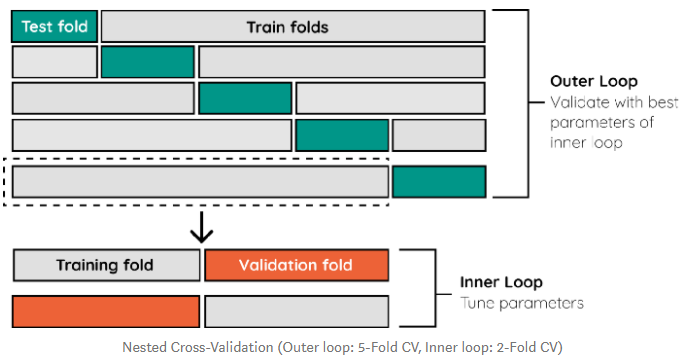

### Approximations: Generalized Cross-validation

Generalized cross-validation provides a **convenient approximation to leave-one-out-cross-validation**, for **linear fitting under squared-error loss**.

A linear fitting method is one for which we can write
\begin{align}
\hat{y} = Sy.
\end{align}
It can be show that for many linear fitting methods, 
\begin{align}
\frac{1}{N}\sum_{n=1}^N[y_n-\hat{f}^{-n}(x_n)]^2 = \frac{1}{N}\sum_{n=1}^N\left[\frac{y_n-\hat{f}(x_n)}{1-S_{nn}}\right]^2,
\end{align}
where $S_{nn}$ is the $n$-th diagonal element of $S$. The GCV approximation is then 
\begin{align}
GCV{\hat{f}} = \frac{1}{N}\sum_{n=1}^N\left[\frac{y_n-\hat{f}(x_n)}{1-trace(S)/N}\right]^2,
\end{align}
by appealing to the approximation $1/(1-x)^2\approx 1+2x$.

## What is the usual blunders/wrong ways in doing cross validation?

It is called **data leakage**, whereby information is inadvently shared between the training and test set, or between the training and validation set within a fold, therefore making the test set or validation set not a good proxy to 'data that we will see if the model is released out in the wild'.

Though this concept seems straightforward, data leakage can be sneaky. Following are by no means an exhaustive list of scenarios that trip people up.

#### Inproper pre-processing

- Features are chosen on the *whole train set* before cv is carried out. Since which feature is important now depends on the whole set information, it sabotages the effectiveness of cv.
    - When trying to impute missing data, sample mean of the whole data set rather than the training set is used, for instance.

- Another example is when **one looks at why model performs badly on test data, and improve accordingly** (see below). But in this sense, optimizing hyper-parameter using cv is suspicious; see the comment about 'multiple comparison' above.

- In cv, the model should be **completely re-trained using just the train data in that fold, though evaluation of errors is on the whole data set**.

- Accidentally call `fit_transform` instead of `transform` when applying the same `Pipeline` in `sklearn` to your test data before making prediction - you do not want to fit the test set!

#### Duplicates

When train and test sets have identical data (duplications).

#### Temporal applications

When future information is used to train the model and test on the past, or when there is strong serial correlations.

Another usual trap is when a split subset only contains samples of certain attribute, i.e. the split fails to account for the stratification of the data. This is called **sampling bias**.

## If a model, after cross-validated, performs badly in the test data. Can we go back and tune the model parameters/hyper-parameters further so that it performs better in the test data?

If one tries to look at how the model performs badly on some instances of the training data, seek to remedy those (saying adding features or better feature engineering) and that brings improvement of model performance on the test data, it is acceptable; see discussions of error analysis in [MLOps_models](MLOps_models.ipynb).

On the other hand, a big taboo is to directly look at instances in the test data to improve model performance.

Relatedly, it should be noted that the purpose of a backtest is to discard bad models, not to improve them. Adjusting models based on the backtest results is a waste of time at best and dangerous at worst. If someone chooses a model just based on superb backtesting results, it is possible that the person is simply just reporting the best backtest result, while the model has no merits (arguably, the more backtests you have done, i.e. the more experience that you have, the easier it is for you to choose a backtest that outperforms). Backtest overfitting can be defined as selection bias on multiple backtests
- Do not backtest until all your research is complete, and your model is settled.
- If backtesting results look promising, you may be (just may be) in luck. If the backtest fails to confirms a model/strategy, start from scratch - resist the temptation of reusing those results.

## `sklearn` implementation details of cross validation

In [ ]:
from sklearn.model_selection import cross_val_score
estimator = svm.SVC(kernel='linear', C=1)
scores = cross_val_score(estimator, X, y, cv=5, scoring=None)

The inputs of `cross_val_score`
- **`estimator`**: estimator object with method `fit`, the object to use to fit the data. You can even pass in a whole `pipeline` to `cross_val_score`.
- **`X`**: data to fit
- **`y`**: labels
- **`scoring`**: A `str` (see [evaluation_metrics_and_information_criterions](evaluation_metrics_and_information_criterions.ipynb)) or a scorer callable object/function with signature `scorer(estimator, X, y)` which should return only a single value.
- **`cv`**: `int`, cross-validation generator or an iterable, default=None
Determines the cross-validation splitting strategy. Possible inputs for cv are:
    
    - `None`, to use the default 5-fold cross validation for stratified KFold,

    - `int`, to specify the number of folds in a `(Stratified)KFold`,

    - CV splitter (see below),

    - An iterable yielding (train, test) splits as arrays of indices.

## What are CV splitters in `sklearn`?

CV splitters are also called cross validation iterators in `sklearn` [document](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators). It is a generator, which implments `split` method on `X` that produces indices that can be used to generate dataset splits according to different cross validation strategies. It is also be passed as an argument to `cv` in `cross_val_score`. The usual ones mentioned above all have `sklearn` implmentations:

In [ ]:
# K-fold
from sklearn.model_selection import KFold
kf = KFold(n_splits=2)
# Repeated K-fold
from sklearn.model_selection import RepeatedKFold
rkf = RepeatedKFold(n_splits=2, n_repeats=2, random_state=random_state)
# Leave One Out
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
# ShuffleSplit - not mentioned above, but simply a user defined number of independent train/test splits.
from sklearn.model_selection import ShuffleSplit
ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
# Stratified K-fold
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3)

In < Advances in Financial Machine Learning >, custom-made splitter such as purged K-fold is defined to deal with cv on time-series; see description of these techniques below.

## How to use `sklearn` and cv to fine-tune hyperparameters of the models?

### Exhaustive Grid Search

`GridSearchCV` uses cross-validation to evaluate all the possible combinations of hyperparameter values. 

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = [{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
estimator = RandomForestRegressor()
grid_search = GridSearchCV(estimator, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X, y)
grid_search.best_params_
grid_search.best_estimator_

All inputs are those with `cross_val_score`, e.g. you are able to pass in a `pipeline` to grid search as well. One of the few things worths mentioning is `param_grid`. It can either be a `dict` of a list of `dict`, where the keys are the hyperparameter to the `estimator`, and values are lists of candidate values of that hyperparameter. For each element (`dict`) in the list of `param_grid`, all combinations of hyperparameters in the list are tried in the cv.

Another input to `GridSearchCV` is `refit`, which is `True` by default: once it finds the best estimator using cross-validation, it retrains it on the whole training set. This is usually a good idea, since feeding it more data will likely improve its performance.

### Randomized Parameter Optimization

The grid search approach is fine when you are exploring relatively few combinations, but when the hyperparameter search space is large, the ususal curse of dimensionality arises. Just as Monte Carlo methods is the answer to high-dimension difficulty in numerical integration, it is often preferable to use `RandomizedSearchCV` instead. This class can be used in much the same way as the `GridSearchCV` class, but instead of trying out all possible combinations, it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration.

Specifying how parameters should be sampled is done using a dictionary, very similar to specifying parameters for `GridSearchCV`. Additionally, a computation budget, being the number of sampled candidates or sampling iterations, is specified using the `n_iter` parameter. For each parameter, either a distribution over possible values or a list of discrete choices (which will be sampled uniformly) can be specified.

<A>

You can also use `keras_tuner` to tune `sklearn` models; see [efficient_deep_learning_and_optimization](http://localhost:8888/notebooks/machine-learning/meta_learning/efficient_deep_learning_and_optimization.ipynb)

## What is a good visualization tool for fine-tuning models using CV?

The proper way of choosing multiple hyperparameters of an estimator IS of course grid search or similar methods that select the hyperparameter with the maximum score on a validation set or multiple validation sets. 
- Note that if we optimized the hyperparameters based on a validation score the validation score is biased and not a good estimate of the generalization any longer. To get a proper estimate of the generalization we have to compute the score on another test set.

However, it is sometimes helpful to plot the influence of a single hyperparameter on the training score and the validation score to find out whether the estimator is overfitting or underfitting for some hyperparameter values.

The function `validation_curve` can help in this case, which computes training and test scores for varying parameter values.

In [ ]:
import numpy as np
from sklearn.model_selection import validation_curve
from sklearn.datasets import load_iris
from sklearn.linear_model import Ridge

np.random.seed(0)
X, y = load_iris(return_X_y=True)
indices = np.arange(y.shape[0])
np.random.shuffle(indices)
X, y = X[indices], y[indices]

train_scores, valid_scores = validation_curve(
    Ridge(), X, y, 
    param_name="alpha", param_range=np.logspace(-7, 3, 3), 
    cv=5)

The inputs of `validation_curve` is similar to that of `cross_val_score` aforementioned, except for the following

- **`param_name`** `str` Name of the parameter that will be varied.

- **`param_range`** array-like of shape `(n_values,)`.  The values of the parameter that will be evaluated.

## What is the difference between a learning curve and a validation curve?

- A learning curve shows the generalization performance—the performance only on testing data, plotted against the amount of training data used. 
- A validation graph shows the generalization performance as well as the performance on the training data, but plotted against some model parameter. Validation graphs generally are shown for a fixed amount of training data.

The implementation of `learning_curve` is introduced in [MLOps-models](MLOps-models.ipynb).

## What is a good CV strategy for time-series?

Use a rolling split, to make sure we do not use the future to predict the past:

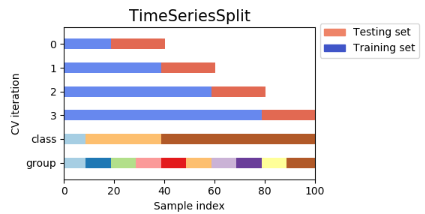

It is implemented in the cv splitter `timeseriessplit` in `sklearn`. 

On a closer examination, however, there is more to be said. Time series, especially financial time series, typically have non-zero serial correlations. For the rolling split approach above, it is possible that neighboring period data is split into training and testing data. Serial correlation would mean that $(X_t, y_t)\approx(X_{t+1}, y_{t+1})$ (in the extreme case that correlation is $1$, $(X_t, y_t)=(X_{t+1}, y_{t+1})$), and essentially we have a repetition of data in the training vs. testing data. This is not unlike leakage, and as in leakage, the model performance will be overstated by CV. In fact, an incarnation of this pheonomemon is as $K\rightarrow T$ ($K$ as in K-fold, and $T$ here represents the sample size of the time-series data), the model performance by CV will keep improving. 

To avoid the problem above, [< Advances in Financial Machine Learning >](https://www.evernote.com/shard/s191/nl/21353936/49556302-bb13-4b64-9153-2ed8883dc48a?title=Advances%20in%20Financial%20Machine%20Learning) proposes two possible solutions: **purging** and **embargo**, basically extending the rolling split aforementioned by allowing for gaps in choosing the training and testing samples, so that they are (arguably) less correlated.

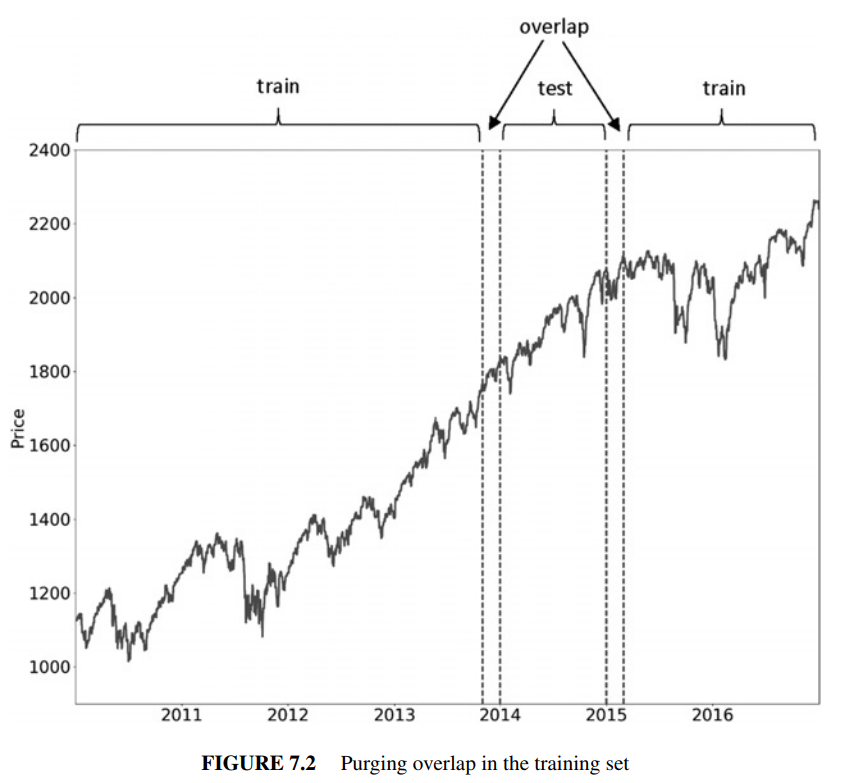

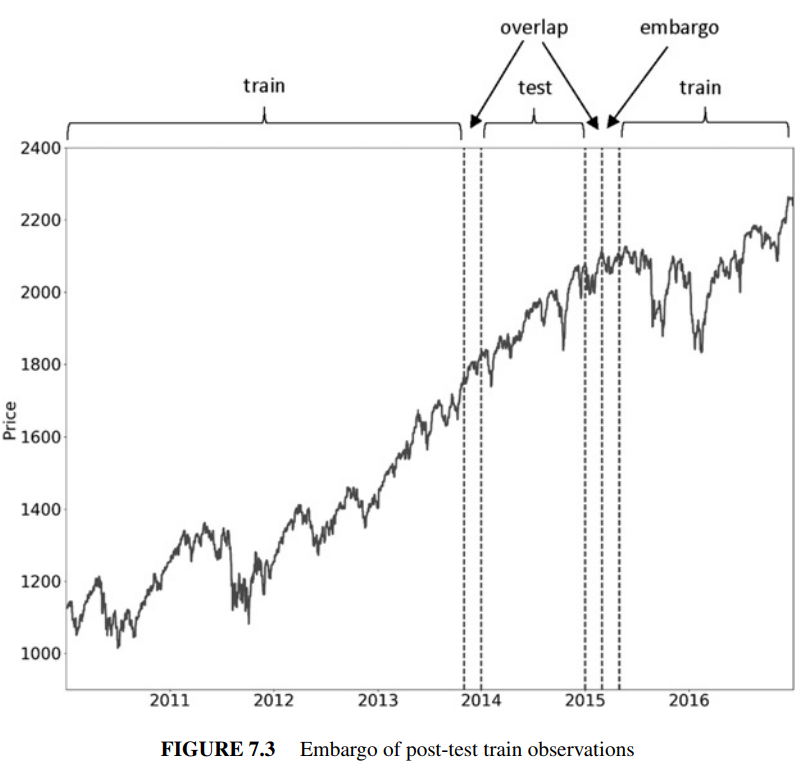


## Quant Trading algos typically require time-series backtesting, which can be viewed as CV on time-series. What are the strategies?

[< Algorithmic Trading >](https://www.evernote.com/shard/s191/nl/21353936/d7787d3b-4db3-c2f7-830f-6865f4403ee8?title=Algorithmic%20Trading%20Winning%20Strategies%20and%20Their%20Rationale), Chapter 1 discusses three ways.
- **Hypothesis Testing**. Aiming for high Sharpe ratio, implicitly assuming a normal distribution. The testing of statistically significant alpha in factor models falls in this camp as well.
- **Simulation of historical prices**. Simulate a time-series of prices of the same length and the first few moments as the true data, then apply the strategy on each of the simulated time series. **The less the fraction of simulated returns that exceeds the one on true data, the better the strategy. The rationale, or the assumption is, for a strategy to be successful, it needs to capture what in the true data beyond the first few moments, but I am still to be convinced: if a strategy works well on similar time-series, is it not a good sign as well?**.
- **Simulation of comparable trades**. This idea is said to be from this [paper](https://www.evernote.com/shard/s191/nl/21353936/0190b120-5739-4358-958c-a856b18f27bc?title=Foundations%20of%20Technical%20Analysis:%20Computational%20Algorithms,%20Statistical%20Inference,%20and%20Empirical%20Implementation). Similar trades are simulated with the constraint that the **number of long and short entry trades is the same as in the backtest, and with the same average holding period for the trades**. We then measure what fraction of such sets of trades has average return greater than or equal to the backtest average return. The intuition can be explained as **assessing how strong the strategy is in beating similar strategies**.

## What are the usual traps in backtesting?
These are summarized in [< Algorithmic Trading >](https://www.evernote.com/shard/s191/nl/21353936/d7787d3b-4db3-c2f7-830f-6865f4403ee8?title=Algorithmic%20Trading%20Winning%20Strategies%20and%20Their%20Rationale) Chapter 1.

- **Look-ahead bias**: this is essentially data leakeage in a CV lingo.
- **Data-snooping**: otherwise known as model overfitting.
- **Survivorship bias**
- **Financial data specific quirks**
    - Stock split    
    - Ex-dividend date
    - Primary vs consolidated prices: there is not one, but multiple 'prices' due to the various exchanges the security is traded on. When you train on one price but execute/predict using another type of price, it causes covariate shift.
    - 'Continuous contract' futures price: depends on the rolling convention on futures contracts.
    - Futures close vs settlement price: the two are different!
- **Regime shift**
    - regulation change: e.g. the uptick rule and the enactment of alternative uptick rule
    - liquidity change: e.g. single-name CDS liquidity never recovers to its pre-crisis level.

## Known bugs in `sklearn` Cross Validation

These two are documented in [< Advanced in Financial Machine Learning >](https://www.evernote.com/shard/s191/nl/21353936/d7787d3b-4db3-c2f7-830f-6865f4403ee8?title=Algorithmic%20Trading%20Winning%20Strategies%20and%20Their%20Rationale)
- Scoring functions do not know classes_, as a consequence of sklearn’s reliance on numpy arrays rather than pandas series: [here](https://github.com/scikitlearn/scikit-learn/issues/6231).
- `cross_val_score` will give different results because it passes weights to the `fit` method, but not to the `log_loss` method: [here](https://github.com/scikitlearn/scikit-learn/issues/9144).

## References

- [< Data Science for Business >](https://www.evernote.com/shard/s191/nl/21353936/b2cbc278-517e-43d1-aff9-10b0afeaa2e4?title=TensorFlow%20Is%20Open-Source,%20But%20Why?%20%7C%20by%20Haifeng%20Jin%20%7C%20Nov,%202022%20%7C%20Towards%20Data%20Science), Chapter 5.
- [ESL](https://www.evernote.com/shard/s191/nl/21353936/c2a0e9ac-da49-4fee-8701-3cd70fc42134?title=The%20Elements%20of%20Statistical%20Learning_print12.pdf), Chapter 7.10
- sklearn document, [Section 3.1](https://scikit-learn.org/stable/modules/cross_validation.html), [3.2](https://scikit-learn.org/stable/modules/grid_search.html)
- [< Advances in Financial Machine Learning >](https://www.evernote.com/shard/s191/nl/21353936/49556302-bb13-4b64-9153-2ed8883dc48a?title=Advances_in_Financial_Machine_Learning.pdf), Chapters 7, 9, 11.
- [Validating your Machine Learning Model](https://towardsdatascience.com/validating-your-machine-learning-model-25b4c8643fb7)
- [< Algorithmic Trading: Winning Strategies and Their Rationale >](https://www.evernote.com/shard/s191/nl/21353936/d7787d3b-4db3-c2f7-830f-6865f4403ee8?title=Algorithmic%20Trading%20Winning%20Strategies%20and%20Their%20Rationale), Chapter 1.